In [ ]:
# 기존 "SubwordTextEncoder" 로 토큰화한 부분을 "koElectra" 토크나이저로 전환
# 같은 조건에서 손실이 줄어들고, 정확도가 올랐음
# 하지만 평가채팅에서 적절하지 않은 답변을 함

#### Base Settings

##### Library

In [ ]:
# !pip install transformers

In [ ]:
# Library import

## pandas
import pandas as pd

import gdown
import zipfile as zf
from tqdm import tqdm
import nltk

import os
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import string
from collections import Counter
import random

# shikit learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow as keras
from keras import layers, Input, Sequential, Model
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D, \
                                    TextVectorization, GlobalAveragePooling2D
import tensorflow_datasets as tfds

from transformers import ElectraTokenizer

##### Parmas

In [ ]:
RAND_SEED = 83
random.seed(RAND_SEED)

NUM_TEXT_DATA       = 1             #📌 사용할 데이터 비율
MAX_LENGTH          = 30            #📌 문장 길이
BATCH_SIZE          = 64
BUFFER_SIZE         = 20000
NUM_LAYERS          = 2
D_MODEL             = 512
NUM_HEADS           = 4
DFF                 = 256
DROPOUT             = 0.1
VOCAB_SIZE          = 10000
EPOCHS              = 10

### Data handling

In [ ]:
def collect_json_file(path):
    """
    폴더의 JSON 파일을 모두 모아서 리스트로 반환하는 함수
    
    PARAMS :
        path : JSON 파일이 있는 폴더 경로
    RETURN :
        json_list : path 폴더 안에 있는 모든 JSON 파일의 리스트
    """
    
    file_list = os.listdir(path)

    json_list = []
    for file_name in file_list:
        if '.json' in file_name:
            json_list.append(file_name)

    return json_list

In [ ]:
def parsing_corpus(js):
    """
    JSON 파일에서 질문과 답변 데이터를 추출하여
    판다스 데이터프레임으로 반환하는 함수

    PARAMS :
        js : JSON 파일 이름
    RETURN :
        df_qa : 질문과 답변 판다스 데이터프레임
    """

    Q1_list = [js[x]["talk"]["content"]["HS01"] for x in range(len(js))]
    Q2_list = [js[x]["talk"]["content"]["HS02"] for x in range(len(js))]
    Q3_list = [js[x]["talk"]["content"]["HS03"] for x in range(len(js))]
    A1_list = [js[x]["talk"]["content"]["SS01"] for x in range(len(js))]
    A2_list = [js[x]["talk"]["content"]["SS02"] for x in range(len(js))]
    A3_list = [js[x]["talk"]["content"]["SS03"] for x in range(len(js))]

    df_qa = pd.DataFrame({"Q1":Q1_list,"A1":A1_list,"Q2":Q2_list,"A2":A2_list,"Q3":Q3_list,"A3":A3_list})

    return df_qa

#### 감성 대화 말뭉치

- [감성 대화 말뭉치](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86)



2020년/10,000문장 (음성), 27만문장 (코퍼스)



In [ ]:
# 구글드라이브에서 데이터파일(.json) 불러와서 폴더에 저장

## 데이터파일 불러올 URL
url_list = ["https://drive.google.com/file/d/1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg/view?usp=sharing",
            "https://drive.google.com/file/d/1lwHywo0OIItRgOv-nK_M_tlxTD_HhG-c/view?usp=sharing"]

for idx, val in enumerate(url_list):
    data_url = val
    file_name = f"donwload_{idx}.zip"
    ### unzip_path = "data/emotion/"
    unzip_path = "./data/"

    ### 데이터 다운로드
    file_id = "https://drive.google.com/uc?id=" + data_url.split('/')[-2]
    gdown.download(file_id, file_name)

    ### 압축풀기
    files = zf.ZipFile(file_name)
    files.extractall(unzip_path)
    files.close()

## 데이터파일(.json)
json_list = collect_json_file(unzip_path)
print(f"\nJSON 파일 개수 : {len(json_list)}개")
print(json_list)

## JSON 파일에서 데이터 추출하기
print(f"데이터 처리중...")
with tqdm(total=len(json_list)) as pbar:
    for idx, val in enumerate(json_list):
        with open(unzip_path+json_list[idx]) as f:
            js = json.loads(f.read())
            if "Training" in str(val):
                df_train = parsing_corpus(js)
            elif "Validation" in str(val):
                df_val = parsing_corpus(js)
        pbar.update()
print(f"\n1번째 파일의 크기: {df_train.shape}")
print(f"2번째 파일의 크기: {df_val.shape}")

Downloading...
From: https://drive.google.com/uc?id=1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg
To: /tf/s3p/donwload_0.zip
100%|██████████| 8.30M/8.30M [00:02<00:00, 2.90MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lwHywo0OIItRgOv-nK_M_tlxTD_HhG-c
To: /tf/s3p/donwload_1.zip
100%|██████████| 993k/993k [00:00<00:00, 2.28MB/s]



JSON 파일 개수 : 2개
['░¿╝║┤δ╚¡╕╗╣╢─í(├╓┴╛╡Ñ└╠┼═)_Training.json', '░¿╝║┤δ╚¡╕╗╣╢─í(├╓┴╛╡Ñ└╠┼═)_Validation.json']
데이터 처리중...


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


1번째 파일의 크기: (51628, 6)
2번째 파일의 크기: (6640, 6)


In [ ]:
# # 데이터 직접 업로드, 불러오기
# ## 훈련데이터 불러오기
# json_train = open("감성대화말뭉치(최종데이터)_Training.json")
# df_train = parsing_corpus(json.loads(json_train.read()))

# ## 검증데이터 불러오기
# json_val = open("감성대화말뭉치(최종데이터)_Validation.json")
# df_val = parsing_corpus(json.loads(json_val.read()))

In [ ]:
print(f"질문1 : {df_train.iloc[RAND_SEED,0]}")
print(f"답변1 : {df_train.iloc[RAND_SEED,1]}")
print(f"질문2 : {df_train.iloc[RAND_SEED,2]}")
print(f"답변2 : {df_train.iloc[RAND_SEED,3]}")
print(f"질문3 : {df_train.iloc[RAND_SEED,4]}")
print(f"답변3 : {df_train.iloc[RAND_SEED,5]}")

질문1 : 요새 회사 끝나고 오면 피곤해서 친구도 보기 귀찮고 휴대전화만 하게 되는 거 같아.
답변1 : 회사 일이 무척 피곤한가 봅니다.
질문2 : 신제품 출시가 얼마 안 남아서 계속 야근했어. 답답한 마음 말할 데도 없고 어쩐지 외롭네.
답변2 : 고생이 많네요. 저에게 편하게 말씀하세요.
질문3 : 
답변3 : 


In [ ]:
df_train.tail()

,Q1,A1,Q2,A2,Q3,A3
51623,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.,경제적인 문제 때문에 막막하시군요. 마음이 편치 않으시겠어요.,아무것도 할 수 없는 내가 무가치하게 느껴지고 실망스러워.,지금 할 수 있는 가장 합리적인 행동은 무엇인가요?,노년층을 위한 경제적 지원이나 부업 같은 것도 알아보아야겠어.,좋은 결과 얻으시길 바랄게요.
51624,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.,건강에 대한 어려움 때문에 기분이 좋지 않으시군요. 속상하시겠어요.,마음 같아서는 다 할 수 있는 일인데 이젠 몸이 안 따라와 주니 화만 나.,어떻게 하면 지금의 기분을 나아지게 할 수 있을까요?,남편과 함께 게이트볼이나 치러 가야겠어. 그럼 기분이 나아질 것 같아.,남편과 함께하는 좋은 외출 시간 되시길 바랄게요.
51625,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.,노후 준비에 대한 어려움 때문에 걱정이 많으시겠어요.,주변 사람들은 다 노후 준비도 잘해두었던데 난 어떻게 해야 할지 모르겠어. 막막하기...,지금의 상황에서 할 수 있는 가장 좋은 행동이 무엇일까요?,남편과 함께 실버 일자리나 노년층을 위한 국가 지원에 대해 자세히 알아보아야겠어.,좋은 정보 많이 얻으셔서 걱정을 좀 덜으셨으면 좋겠어요.
51626,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.,가족과의 문제 때문에 속상하시겠어요.,이제 할 수 있는 일도 없고 이렇게 힘들게 사는 게 불만스럽기만 해.,지금의 감정을 나아지게 할 수 있는 어떤 방법이 있을까요?,함께 친하게 지내던 동네 언니 동생들과 빈자리를 조금이나마 채울까 해.,지인분들과 좋은 시간 보내셨으면 좋겠어요.
51627,남편과 결혼한 지 사십 년이야. 이제 사람 만나는 것도 버겁고 알던 사람도 점점 사라져.,대인관계에 대한 어려움 때문에 걱정되시고 속상하시겠어요.,사람들을 만나는 것이 어려워. 자꾸 사람들을 의심하게만 되고 말이야.,어떻게 하면 지금의 상황에 변화를 만들어낼 수 있을까요?,사람들을 볼 때 의심하고 불신하는 마음을 억눌러야겠어. 사람들을 색안경을 끼고 보지...,원하시는 대로 가지고 계시던 걱정이 잘 해결되셨으면 좋겠어요.


In [ ]:
# # 모든턴 사용
# df_list = [df_train, df_val]
# for df in df_list:
#     df_1 = df[["Q1","A1"]]
#     df_2 = df[["Q2","A2"]]
#     df_3 = df[["Q3","A3"]]

#     df_1.columns = ["Q1", "A1"]
#     df_2.columns = ["Q1", "A1"]
#     df_3.columns = ["Q1", "A1"]

#     if df.shape == df_train.shape:
#         qna_train = pd.DataFrame()
#         qna_train = pd.concat([qna_train,df_1])
#         qna_train = pd.concat([qna_train,df_2])
#         qna_train = pd.concat([qna_train,df_3])

#         qna_train.reset_index(drop=True, inplace=True)
#         filt = qna_train["A1"].str.len() < 3
#         qna_train.drop(index=qna_train[filt].index, inplace=True)
#     else:
#         qna_val = pd.DataFrame()
#         qna_val = pd.concat([qna_val,df_1])
#         qna_val = pd.concat([qna_val,df_2])
#         qna_val = pd.concat([qna_val,df_3])

#         qna_val.reset_index(drop=True, inplace=True)
#         filt = qna_val["A1"].str.len() < 3
#         qna_val.drop(index=qna_val[filt].index, inplace=True)

# print(qna_train.shape, qna_val.shape)
# qna_train.sample(5, random_state=RAND_SEED)

In [ ]:
# 1턴만 사용
df_list = [df_train, df_val]
for df in df_list:
    if df.shape == df_train.shape:
        qna_train = df[["Q1","A1"]].copy()
    else:
        qna_val = df[["Q1","A1"]].copy()

print(qna_train.shape, qna_val.shape)
qna_train.sample(5, random_state=RAND_SEED)

(51628, 2) (6640, 2)


,Q1,A1
18720,이제 암 말기로 항암제도 듣질 않아. 너무 고통스럽게 죽을 것 같아.,암 때문에 너무 무서우시겠어요.
7696,나는 뭘 해도 안 될 것 같아.,오늘 속상한 일이 있으셨나요? 왜 그런 생각을 하셨는지 궁금해요.
24555,친구가 많이 힘든 상황에 있는데 연락이 없어져서 불안해.,친구를 걱정해주시는 따뜻한 마음씨를 가지셨네요. 지금 많이 불안하시겠어요.
28578,요즈음같이 코로나일구로 외출을 억제하다 보니 돈도 별로 필요 없는 것 같아.,그렇지요? 인터넷으로 필요하신 거 주문하시곤 하세요?
31094,딸이 아픈데 약을 제대로 챙겨 먹지 않아서 화가나서 화를 냈어.,약을 잘 챙기지 않은 딸에게 화를 내셨군요.


In [ ]:
train_rate = int(qna_train.shape[0] * NUM_TEXT_DATA)
train_data = qna_train.sample(train_rate, random_state=RAND_SEED).copy()

val_rate = int(qna_val.shape[0] * NUM_TEXT_DATA)
val_data = qna_val.sample(val_rate, random_state=RAND_SEED).copy()

print(f"학습 데이터셋 개수: {train_data.shape}")
print(f"검증 데이터셋 개수: {val_data.shape}")
qna_train.sample(5, random_state=RAND_SEED)

학습 데이터셋 개수: (51628, 2)
검증 데이터셋 개수: (6640, 2)


,Q1,A1
18720,이제 암 말기로 항암제도 듣질 않아. 너무 고통스럽게 죽을 것 같아.,암 때문에 너무 무서우시겠어요.
7696,나는 뭘 해도 안 될 것 같아.,오늘 속상한 일이 있으셨나요? 왜 그런 생각을 하셨는지 궁금해요.
24555,친구가 많이 힘든 상황에 있는데 연락이 없어져서 불안해.,친구를 걱정해주시는 따뜻한 마음씨를 가지셨네요. 지금 많이 불안하시겠어요.
28578,요즈음같이 코로나일구로 외출을 억제하다 보니 돈도 별로 필요 없는 것 같아.,그렇지요? 인터넷으로 필요하신 거 주문하시곤 하세요?
31094,딸이 아픈데 약을 제대로 챙겨 먹지 않아서 화가나서 화를 냈어.,약을 잘 챙기지 않은 딸에게 화를 내셨군요.


#### "이연준 챗봇" 학습 데이터

In [ ]:
data = {"Q1" : [
                "너는 누구니?",
                "챗봇의 이름이 뭐야?",
                "당신은 누구십니까?",
                "당신의 이름은 무엇입니까?",
                "챗봇 이름이 뭐야?",
                "너는 뭐야?",
                "너는 자신을 무엇이라고 생각하니?",
                "너는 이름이 무엇이니?",
                "당신은 누군가요?",
                "너는 누구야?"
                ],
        "A1" : [
                "저는 이연준님이 만든 챗봇이에요",
                "저의 이름은 이연준의 챗봇 입니다.",
                "저는 이연준이 만든 챗봇입니다",
                "저의 이름은 이연준의 챗봇 이에요.",
                "저는 챗봇이에요, 이연준이 저를 만들었어요.",
                "저는 이연준 챗봇입니다.",
                "저는 이연준이 만든 챗봇이라고 생각해요",
                "저는 이연준님의 챗봇 이라고 합니다.",
                "저는 챗봇입니다.",
                "저는 이연준이 만든 챗봇입니다."
                ],
        }

leeyeonjun_df = pd.DataFrame(data)
train_data = pd.concat([train_data,leeyeonjun_df])

In [ ]:
# 질문과 답변을 분리
q_train, a_train = list(train_data["Q1"]), list(train_data["A1"])
q_val, a_val = list(val_data["Q1"]), list(val_data["A1"])

# 정규식으로 ?!. 앞에 공백 추가하고, 양 옆 공백 제거
q_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_train]
a_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_train]
q_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_val]
a_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_val]

print(f"{len(q_train)}, {len(a_train)}, {len(q_val)}, {len(a_val)}")

51638, 51638, 6640, 6640


In [ ]:
random.seed(RAND_SEED)
for i in random.sample(range(len(q_train)), 5):
    print(f"{'-'*50}\n질문 : {q_train[i]}\n답변 : {a_train[i]}")

--------------------------------------------------
질문 : 나는 청소부가 되고 싶은데 사람들이 이상하게 보지 않을까 무서워 .
답변 : 하고 싶은 직업이 사람들에게 이상하게 비치지 않을까 걱정하시는 것이군요 .
--------------------------------------------------
질문 : 얼마 전에 길에서 고등학교 친구를 우연히 만났는데 너무 당황했어 .
답변 : 오랜만에 친구분을 만났는데 왜 당황하셨어요 ?
--------------------------------------------------
질문 : 근래 성적이 자꾸 떨어져서 혼란스러워 .
답변 : 낮아지는 성적 때문에 혼란스러우시군요 .
--------------------------------------------------
질문 : 요즘 회사에서 은근히 퇴직하라고 압박이 들어오는 거 같아 .  고민 중이야 .
답변 : 퇴직은 인생에서 가장 큰 고민거리죠 !  어떻게 하실 건가요 ?
--------------------------------------------------
질문 : 우리 팀 실적이 부진해서 그동안 스트레스를 많이 받았었어 .
답변 : 업무 스트레스로 많이 속상하셨겠어요 .


#### 토큰화

In [ ]:
# KoElectra 의 토크나이저 사용
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
START_TOKEN, END_TOKEN = tokenizer.vocab['[CLS]'], tokenizer.vocab['[SEP]']
VOCAB_SIZE = tokenizer.vocab_size

print(f"{'START_TOKEN'  :>12s} = {tokenizer.vocab['[CLS]']}")
print(f"{'END_TOKEN'    :>12s} = {tokenizer.vocab['[SEP]']}")
print(f"{'VOCAB_SIZE'   :>12s} = {VOCAB_SIZE}")

 START_TOKEN = 2
   END_TOKEN = 3
  VOCAB_SIZE = 35000


In [ ]:
# [item for item in dir(tokenizer) if not item.startswith('_')]

In [ ]:
# 토크나이저의 토큰과 부여된 정수 확인
vocab_keys = list(tokenizer.vocab.keys())
vocab_values = list(tokenizer.vocab.values())

print(f"📌{'토큰':>3s} : {'정수'}")
for i in range(10):
    print(f"{vocab_keys[i]:>8s} : {vocab_values[i]}")

📌 토큰 : 정수
   [PAD] : 0
   [UNK] : 1
   [CLS] : 2
   [SEP] : 3
  [MASK] : 4
       ! : 5
       " : 6
       # : 7
       $ : 8
       % : 9


In [ ]:
# 토큰화 예시
sample_text = q_train[RAND_SEED]
print(f"토큰화 이전 : {sample_text}")
print(f"토큰화 이전 : {tokenizer.tokenize(sample_text)}")
print(f"토큰화 이후 : {tokenizer.encode(sample_text)}") # encoding 하면 자동으로 start 토큰과 end 토큰이 부여 된다

토큰화 이전 : 남편이 돈을 못 벌어서 남편이랑 맨날 싸워 .  너무 짜증 나 .
토큰화 이전 : ['남편', '##이', '돈', '##을', '못', '벌', '##어', '##서', '남편', '##이', '##랑', '맨날', '싸워', '.', '너무', '짜증', '나', '.']
토큰화 이후 : [2, 7361, 4007, 2398, 4292, 2684, 2756, 4025, 4129, 7361, 4007, 4294, 16526, 17688, 18, 6395, 13215, 2236, 18, 3]


In [ ]:
# 토큰화 예시
tokens = tokenizer(sample_text)
print(f"{'Sample String':>15s} : {tokenizer.decode(tokenizer.encode(sample_text))}")
print(f"{'input ids':>15s} : {tokens['input_ids']}")
print(f"{'token type ids':>15s} : {tokens['token_type_ids']}")
print(f"{'attention mask':>15s} : {tokens['attention_mask']}")

  Sample String : [CLS] 남편이 돈을 못 벌어서 남편이랑 맨날 싸워. 너무 짜증 나. [SEP]
      input ids : [2, 7361, 4007, 2398, 4292, 2684, 2756, 4025, 4129, 7361, 4007, 4294, 16526, 17688, 18, 6395, 13215, 2236, 18, 3]
 token type ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 attention mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# 토크나이저의 .encode()와 decode() 테스트해보기

## encode() : 텍스트 시퀀스 --> 정수 시퀀스
encoded_q = tokenizer.encode(q_train[RAND_SEED])
encoded_a = tokenizer.encode(a_train[RAND_SEED])

## decode() : 정수 시퀀스 --> 텍스트 시퀀스
decoded_q = tokenizer.decode(encoded_q)
decoded_a = tokenizer.decode(encoded_a)

print (f'디코딩 된 질문 : {decoded_q}')
print (f'인코딩 된 질문 : {encoded_q}')
print (f'\n디코딩 된 답변 : {decoded_a}')
print (f'인코딩 된 답변 : {encoded_a}')

디코딩 된 질문 : [CLS] 남편이 돈을 못 벌어서 남편이랑 맨날 싸워. 너무 짜증 나. [SEP]
인코딩 된 질문 : [2, 7361, 4007, 2398, 4292, 2684, 2756, 4025, 4129, 7361, 4007, 4294, 16526, 17688, 18, 6395, 13215, 2236, 18, 3]

디코딩 된 답변 : [CLS] 남편의 소득 때문에 매일 싸우시는군요. [SEP]
인코딩 된 답변 : [2, 7361, 4234, 7074, 6234, 4073, 7465, 8669, 4114, 4034, 4397, 4150, 18, 3]


In [ ]:
token_q = [tokenizer.decode([x]) for x in encoded_q]
token_a = [tokenizer.decode([x]) for x in encoded_a]
token_vector_q = pd.DataFrame({"Token Q":token_q,"Vector Q":encoded_q})
token_vector_a = pd.DataFrame({"Token A":token_a,"Vector A":encoded_a})
token_vector = pd.concat([token_vector_q, token_vector_a], axis=1)
token_vector

,Token Q,Vector Q,Token A,Vector A
0,[CLS],2,[CLS],2.0
1,남편,7361,남편,7361.0
2,##이,4007,##의,4234.0
3,돈,2398,소득,7074.0
4,##을,4292,때문,6234.0
5,못,2684,##에,4073.0
6,벌,2756,매일,7465.0
7,##어,4025,싸우,8669.0
8,##서,4129,##시,4114.0
9,남편,7361,##는,4034.0


In [ ]:
def tok_pad(q_list, a_list):
    """
    토큰화를 수행하며 시작토큰과 종료토큰을 만들고, 패딩을 추가합니다.
    PARAMS :
        q_list : 질문 문자열 리스트
        a_list : 답변 문자열 리스트
    RETURN :
        q_toked_enc_input : 질문을 토큰화하고, 시작토큰과 종료토큰이 추가된 리스트 (인코더 입력)
        a_toked_dec_input : 답변을 토큰화하고, 시작토큰이 추가된 리스트 (디코더 입력)
        a_toked_dec_label : 답변을 토큰화하고, 종료토큰이 추가된 리스트 (디코더 라벨)
    """
    with tqdm(total=len(q_list)) as pbar:
        q_toked_enc_input, a_toked_dec_input, a_toked_dec_label = [], [], []
        for i in range(len(q_list)):
            q_input = tokenizer.encode(q_list[i])           # 인코더 질문 입력 : 시작토큰 + 텍스트 + 종료토큰
            a_input = tokenizer.encode(a_list[i])[:-1]      # 디코더 답변 입력 : 시작토큰 + 텍스트
            a_label = tokenizer.encode(a_list[i])[1:]       # 디코더 답변 라벨 : 텍스트 + 종료토큰

            q_toked_enc_input.append(q_input)
            a_toked_dec_input.append(a_input)
            a_toked_dec_label.append(a_label)
            
            pbar.update()

        ## 패딩
        q_toked_enc_input = tf.keras.preprocessing.sequence.pad_sequences(
                        q_toked_enc_input, maxlen=MAX_LENGTH, padding='post')
        a_toked_dec_input = tf.keras.preprocessing.sequence.pad_sequences(
                        a_toked_dec_input, maxlen=MAX_LENGTH, padding='post')
        a_toked_dec_label = tf.keras.preprocessing.sequence.pad_sequences(
                        a_toked_dec_label, maxlen=MAX_LENGTH, padding='post')

    return q_toked_enc_input, a_toked_dec_input, a_toked_dec_label

In [ ]:
q_toked_enc_input_train, a_toked_dec_input_train, a_toked_dec_label_train = tok_pad(q_train, a_train)
q_toked_enc_input_val, a_toked_dec_input_val, a_toked_dec_label_val = tok_pad(q_val, a_val)

100%|██████████| 6640/6640 [00:03<00:00, 1825.24it/s]


In [ ]:
print(f"인코더 입력 데이터의 shape : {q_toked_enc_input_train.shape}")
print(f"디코더 입력 데이터의 shape : {a_toked_dec_input_train.shape}")
print(f"디코더 라벨 데이터의 shape : {a_toked_dec_label_train.shape}")

인코더 입력 데이터의 shape : (51638, 30)
디코더 입력 데이터의 shape : (51638, 30)
디코더 라벨 데이터의 shape : (51638, 30)


#### 데이터를 모델에 넣을 수 있도록 구성

In [ ]:
# Train Batch
train_batches = tf.data.Dataset.from_tensor_slices(((q_toked_enc_input_train, a_toked_dec_input_train), a_toked_dec_label_train))

train_batches = train_batches.cache()
train_batches = train_batches.shuffle(BUFFER_SIZE)
train_batches = train_batches.batch(BATCH_SIZE)
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# Validation Batch
val_batches = tf.data.Dataset.from_tensor_slices(((q_toked_enc_input_val, a_toked_dec_input_val), a_toked_dec_label_val))

val_batches = val_batches.cache()
val_batches = val_batches.shuffle(BUFFER_SIZE)
val_batches = val_batches.batch(BATCH_SIZE)
val_batches = val_batches.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# batche 하나를 샘플로 가져오기
for (q_enc_input, a_dec_input), a_dec_label in train_batches.take(1):
    q_enc_input, a_dec_input, a_dec_label  = q_enc_input, a_dec_input, a_dec_label
    break

print(q_enc_input.shape)
print(a_dec_input.shape)
print(a_dec_label.shape)

print(f"\n{q_enc_input[0]}")
print(f"{tokenizer.decode(q_enc_input[0])}\n{'-'*80}")
print(f"{a_dec_input[0]}")
print(f"{tokenizer.decode(a_dec_input[0])}\n{'-'*80}")
print(f"{a_dec_label[0]}")
print(f"{tokenizer.decode(a_dec_label[0])}")

(64, 30)
(64, 30)
(64, 30)

[    2  2126 10509  4070  2252  8760  4110  6457  6243  4139  2048 11318
  2633  4398  4025    18     3     0     0     0     0     0     0     0
     0     0     0     0     0     0]
[CLS] 그 상사가 내 아이디어를 자기 생각인 것처럼 말했어. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
--------------------------------------------------------------------------------
[    2 10509  4070  8760  4110  6457  6243  4139  2048 11318  2633  9448
 10227  4398  5012  7933    18     0     0     0     0     0     0     0
     0     0     0     0     0     0]
[CLS] 상사가 아이디어를 자기 생각인 것처럼 말해서 당황했겠어요. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
--------------------------------------------------------------------------------
[10509  4070  8760  4110  6457  6243  4139  2048 11318  2633  9448 10227
  4398  5012  7933    18     3     0     0     0     0     0     0     0
     0     0     0     0     0     0]
상사가 아이디어를 자기 생각인 것처럼 

### Define the Components
- [Tensorflow : Translate text with Transformer Models](https://www.tensorflow.org/text/tutorials/transformer#the_embedding_and_positional_encoding_layer)

#### The embedding and positional encoding layer

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

(35000, 512)


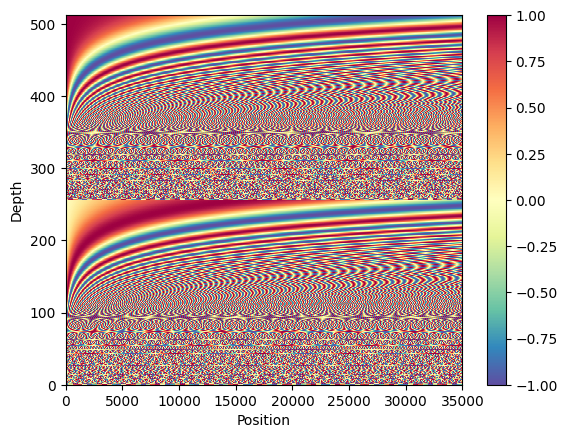

In [ ]:
pos_encoding = positional_encoding(length=VOCAB_SIZE, depth=D_MODEL)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='Spectral_r')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=vocab_size, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
embed_q = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=D_MODEL)
embed_a = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=D_MODEL)

q_emb = embed_q(q_enc_input)
a_emb = embed_a(a_dec_input)
print(f"📌 포지셔널 임베딩을 통과한 Input의 shape\n질문 : {q_emb.shape} / 답변 : {a_emb.shape}")
print(f"📌 마스킹 데이터\n{a_emb._keras_mask[0]}")

📌 포지셔널 임베딩을 통과한 Input의 shape
질문 : (64, 30, 512) / 답변 : (64, 30, 512)
📌 마스킹 데이터
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False False False False]


#### The base attention layer

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### The cross attention layer

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
sample_ca = CrossAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(q_emb.shape)
print(a_emb.shape)
print(sample_ca(a_emb, q_emb).shape)

(64, 30, 512)
(64, 30, 512)
(64, 30, 512)


#### The global self attention layer

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(q_emb.shape)
print(sample_gsa(q_emb).shape)

(64, 30, 512)
(64, 30, 512)


#### The causal self attention layer

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(a_emb.shape)
print(sample_csa(a_emb).shape)

(64, 30, 512)
(64, 30, 512)


In [ ]:
out1 = sample_csa(embed_a(a_dec_input[:, :3])) 
out2 = sample_csa(embed_a(a_dec_input))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

5.9604645e-07

#### The feed forward network

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [ ]:
sample_ffn = FeedForward(D_MODEL, DFF)

print(a_emb.shape)
print(sample_ffn(a_emb).shape)

(64, 30, 512)
(64, 30, 512)


#### The encoder layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF)

print(q_emb.shape)
print(sample_encoder_layer(q_emb).shape)

(64, 30, 512)
(64, 30, 512)


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1, **kwargs):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(q_enc_input, training=False)

# Print the shape.
print(q_enc_input.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 30)
(64, 30, 512)


#### The decoder layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF)

sample_decoder_layer_output = sample_decoder_layer(
    x=a_emb, context=q_emb)

print(a_emb.shape)
print(q_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 30, 512)
(64, 30, 512)
(64, 30, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

output = sample_decoder(
    x=a_dec_input,
    context=q_emb)

# Print the shapes.
print(a_dec_input.shape)
print(q_emb.shape)
print(output.shape)

(64, 30)
(64, 30, 512)
(64, 30, 512)


#### The Transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    inc_input, dec_input = inputs

    inc_output = self.encoder(inc_input)  # (batch_size, context_len, d_model)

    dec_output = self.decoder(dec_input, inc_output)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(dec_output)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [ ]:
transformer = Transformer(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_vocab_size=VOCAB_SIZE,
    target_vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT)

In [ ]:
output = transformer((q_enc_input, a_dec_input))

print(a_dec_input.shape)
print(q_enc_input.shape)
print(output.shape)

(64, 30)
(64, 30)
(64, 30, 35000)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 4, 30, 30)


In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  26851840  
                                                                 
 decoder_1 (Decoder)         multiple                  35255808  
                                                                 
 dense_22 (Dense)            multiple                  17955000  
                                                                 
Total params: 80,062,648
Trainable params: 80,062,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# tf.keras.utils.plot_model(transformer, show_shapes=True)

### Training

#### Set up the optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=1000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

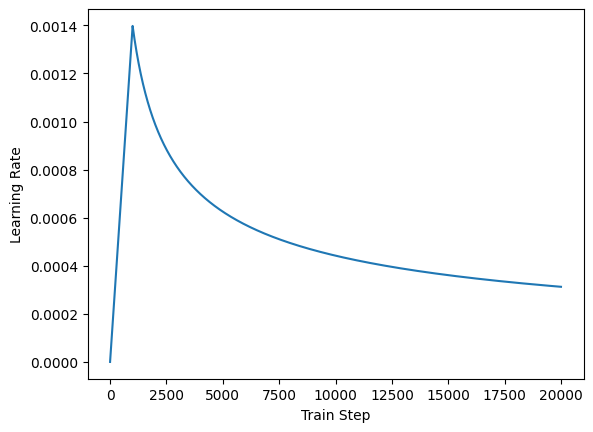

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

plt.plot(learning_rate(tf.range(20000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

#### Train the model

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
%%time
t_history = transformer.fit(train_batches,
                            epochs=EPOCHS,
                            validation_data=val_batches)

Epoch 1/10
807/807 [==============================] - 206s 238ms/step - loss: 3.9135 - masked_accuracy: 0.3897 - val_loss: 2.7608 - val_masked_accuracy: 0.4851
Epoch 2/10
807/807 [==============================] - 182s 225ms/step - loss: 2.6760 - masked_accuracy: 0.4877 - val_loss: 2.6447 - val_masked_accuracy: 0.4969
Epoch 3/10
807/807 [==============================] - 183s 226ms/step - loss: 2.4928 - masked_accuracy: 0.5045 - val_loss: 2.5171 - val_masked_accuracy: 0.5103
Epoch 4/10
807/807 [==============================] - 181s 224ms/step - loss: 2.3578 - masked_accuracy: 0.5183 - val_loss: 2.4339 - val_masked_accuracy: 0.5179
Epoch 5/10
807/807 [==============================] - 176s 218ms/step - loss: 2.2640 - masked_accuracy: 0.5277 - val_loss: 2.3823 - val_masked_accuracy: 0.5245
Epoch 6/10
807/807 [==============================] - 180s 223ms/step - loss: 2.1846 - masked_accuracy: 0.5361 - val_loss: 2.3332 - val_masked_accuracy: 0.5322
Epoch 7/10
807/807 [====================

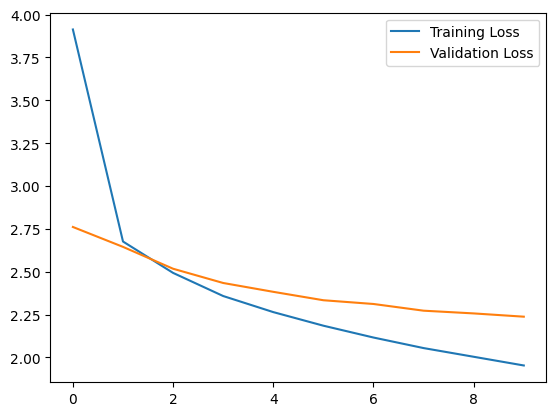

In [ ]:
plt.plot(t_history.history["loss"], label="Training Loss")
plt.plot(t_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(tokenizer.encode(sentence), axis=0)

  output = tf.expand_dims([START_TOKEN], 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = transformer(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size][1:])

  print('질문 : "{}"'.format(sentence))
  print('답변 : "{}"'.format(predicted_sentence))

  return predicted_sentence

def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

### Test Chat

In [ ]:
%%time
output = predict('취업하기 위해서 열심히 준비하고 있지만, 직장을 구하지 못할까봐 걱정되')

질문 : "취업하기 위해서 열심히 준비하고 있지만, 직장을 구하지 못할까봐 걱정되"
답변 : "노후 준비로 걱정이 많으시군요."
CPU times: user 1.34 s, sys: 80.3 ms, total: 1.42 s
Wall time: 1.5 s


In [ ]:
%%time
output = predict('딸이 나에게 선물을 줬어. 그래서 너무 기뻐')

질문 : "딸이 나에게 선물을 줬어. 그래서 너무 기뻐"
답변 : "딸이 갑자기 연락이 와서 당황스러우셨군요."
CPU times: user 1.64 s, sys: 14.8 ms, total: 1.66 s
Wall time: 1.76 s


In [ ]:
%%time
output = predict('너는 누구야?')

질문 : "너는 누구야?"
답변 : "무슨 일이 있으셨나요?"
CPU times: user 1.2 s, sys: 17.8 ms, total: 1.21 s
Wall time: 1.28 s


In [ ]:
%%time
output = predict('아무리 생각해도 너는 멍청한 것 같아')

질문 : "아무리 생각해도 너는 멍청한 것 같아"
답변 : "무슨 일이 있으셨나요?"
CPU times: user 947 ms, sys: 94 ms, total: 1.04 s
Wall time: 1.11 s
